# # Option 1

In [ ]:
sam2 = build_sam2(cfg_path, ckpt_path, device=device)
amg = SAM2AutomaticMaskGenerator(
    model=sam2,

    points_per_side=32,
    points_per_batch=64,

    pred_iou_thresh=0.90,           
    stability_score_thresh=0.95,    

    stability_score_offset=1.0,
    mask_threshold=0.0,

    box_nms_thresh=0.1,             

    crop_n_layers=0,                
    crop_nms_thresh=0.7,            
    crop_overlap_ratio=512 / 1500,  
    crop_n_points_downscale_factor=1, 
    point_grids=None,              

    min_mask_region_area=10,       

    output_mode="binary_mask",
    use_m2m=False,
    multimask_output=True
)

# # Option 2

In [ ]:
sam2 = build_sam2(cfg_path, ckpt_path, device=device)
amg  = SAM2AutomaticMaskGenerator(
    model=sam2,

    points_per_side=64,
    points_per_batch=128,

    pred_iou_thresh=0.90,           
    stability_score_thresh=0.95,    

    stability_score_offset=1.0,
    mask_threshold=0.0,

    box_nms_thresh=0.05,             

    crop_n_layers=2,               
    crop_nms_thresh=0.05,            
    crop_overlap_ratio=512 / 1500, 
    crop_n_points_downscale_factor=1, 
    point_grids=None,              

    min_mask_region_area=0,       

    output_mode="binary_mask",
    use_m2m=False,
    multimask_output=True
)

# # Hyperparameter Tuning Test

In [2]:
import cv2, torch, random, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

device           = "cuda" if torch.cuda.is_available() else "cpu"
cfg_path         = "configs/sam2.1/sam2.1_hiera_l.yaml"      
ckpt_path        = "./checkpoints/sam2.1_hiera_large.pt"

In [3]:
sam2 = build_sam2(cfg_path, ckpt_path, device=device)
amg = SAM2AutomaticMaskGenerator(
    model=sam2,

    points_per_side=32,
    points_per_batch=64,

    pred_iou_thresh=0.90,           
    stability_score_thresh=0.95,    

    stability_score_offset=1.0,
    mask_threshold=0.0,

    box_nms_thresh=0.1,             

    crop_n_layers=0,                
    crop_nms_thresh=0.7,            
    crop_overlap_ratio=512 / 1500,  
    crop_n_points_downscale_factor=1, 
    point_grids=None,              

    min_mask_region_area=10,       

    output_mode="binary_mask",
    use_m2m=False,
    multimask_output=True
)

In [4]:
img_path         = "/home/s2behappy4/data/gyuhyeong/MLLM_Anomaly/Demo_data/000_variant12/image.png"
image_bgr        = cv2.imread(img_path)
assert image_bgr is not None, "이미지 경로 확인"
h, w             = image_bgr.shape[:2]

In [5]:
raw_masks        = amg.generate(np.ascontiguousarray(image_bgr))
raw_masks        = [m["segmentation"].astype(np.bool_) for m in raw_masks]
print(f"SAM2 mask count: {len(raw_masks)}")

SAM2 mask count: 135


In [6]:
areas            = [m.sum() for m in raw_masks]
sorted_idx       = np.argsort(areas)        
union_prev       = np.zeros((h, w), dtype=np.bool_)
clean_masks      = []

for idx in sorted_idx:
    m            = raw_masks[idx]
    m_clean      = m & (~union_prev)        
    if m_clean.sum() > 0:                   
        clean_masks.append(m_clean)
        union_prev |= m_clean
print(f"후처리 후 mask count: {len(clean_masks)}")

union_all        = union_prev.copy()
inv_mask         = (~union_all)
inv_pixels       = int(inv_mask.sum())
use_inv          = inv_pixels >= 50           
if use_inv:
    clean_masks.append(inv_mask)
    print(f"Inversion mask generation, pixel: {inv_pixels}")
else:
    print("Inversion mask skip")

후처리 후 mask count: 135
Inversion mask generation, pixel: 130586


중복되는 pixel 존재? : False
Mask가 이미지를 모두 cover? : True


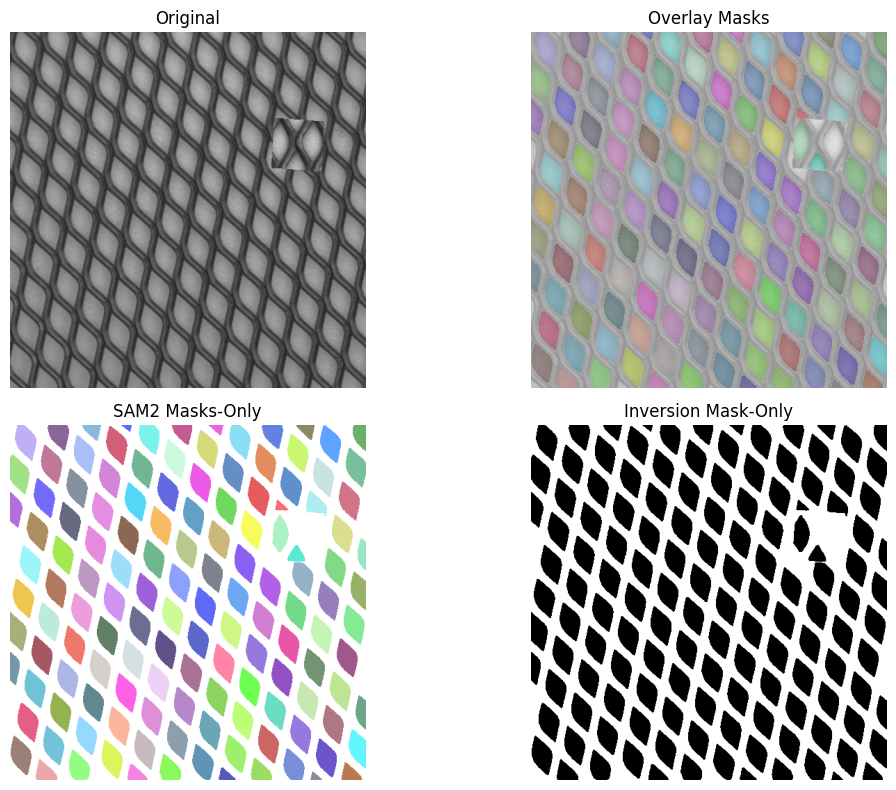

In [7]:
stack            = np.stack(clean_masks).astype(np.uint8)
overlap_test     = (stack.sum(axis=0) > 1).any()
print(f"중복되는 pixel 존재? : {overlap_test}")

coverage_test    = stack.sum(axis=0).all()
print(f"Mask가 이미지를 모두 cover? : {coverage_test}")

random.seed(42)
mask_colors = [(random.randint(80,255), random.randint(80,255), random.randint(80,255))
               for _ in range(len(clean_masks))]
if use_inv:                               
    mask_colors[-1] = (255,255,255)       

masks_only = np.zeros_like(image_bgr)
for m, col in zip(clean_masks, mask_colors):
    masks_only[m] = col

overlay   = cv2.addWeighted(image_bgr, 0.5, masks_only, 0.5, 0)

inv_only  = np.zeros_like(image_bgr)
if use_inv:
    inv_only[inv_mask] = (255,255,255)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1); plt.title("Original");         plt.axis('off')
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))

plt.subplot(2,2,2); plt.title("Overlay Masks");    plt.axis('off')
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))

plt.subplot(2,2,3); plt.title("SAM2 Masks-Only");       plt.axis('off')
plt.imshow(cv2.cvtColor(masks_only, cv2.COLOR_BGR2RGB))

plt.subplot(2,2,4); plt.title("Inversion Mask-Only");   plt.axis('off')
plt.imshow(cv2.cvtColor(inv_only, cv2.COLOR_BGR2RGB))

plt.tight_layout(); plt.show()